In [1]:
import tcav.utils_plot as utils_plot
from tcav.utils import pickle_load
from config import root_dir, model_to_run, bottlenecks, concepts, version, num_random_exp, max_examples, run_parallel, num_workers
import matplotlib.pyplot as plt
import numpy
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import itertools

In [3]:
project_names = '3layer-mnist'
keyword = 'mnist_purple'
results_lst = []

# results(random同士なし)をロード
results_path = os.listdir(root_dir + 'log/' + project_names + '/tcavs')
results_path.sort()
for path in results_path:
    if keyword in path:
        if project_names in path:
            results = pickle_load(root_dir + 'log/' + project_names + '/tcavs/' + path)
            results_lst.append(results)
            print(path)

3layer-mnist_conv1_conv2_conv3:mnist_purple:mnist_0_mnist_1_mnist_2_mnist_3_mnist_4_mnist_5_mnist_6_mnist_7_mnist_8_mnist_9_50_0618
3layer-mnist_conv1_conv2_conv3:mnist_purple:simple-blue_simple-green_simple-red_simple-yellow_simple-purple_50_0618
trueCAV-3layer-mnist_conv1_conv2_conv3:mnist_purple:mnist_0_mnist_1_mnist_2_mnist_3_mnist_4_mnist_5_mnist_6_mnist_7_mnist_8_mnist_9_50_0618
trueCAV-3layer-mnist_conv1_conv2_conv3:mnist_purple:simple-blue_simple-green_simple-red_simple-yellow_simple-purple_50_0618


## TCAV スコア

In [295]:
import importlib
importlib.reload(utils_plot)

print(len(results_lst[0]))
list(results_lst[0][0].keys())

1500


['cav_key',
 'cav_concept',
 'negative_concept',
 'target_class',
 'cav_accuracies',
 'i_up',
 'val_directional_dirs',
 'alpha',
 'bottleneck']

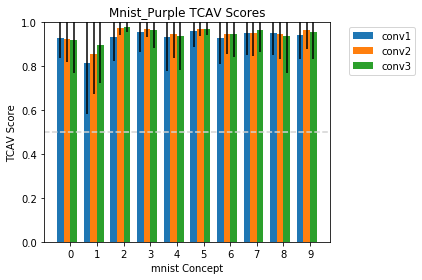

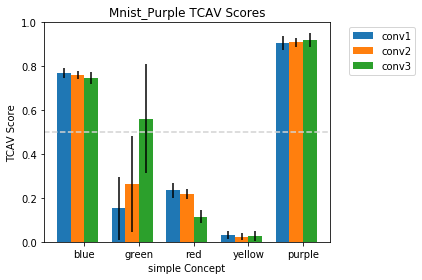

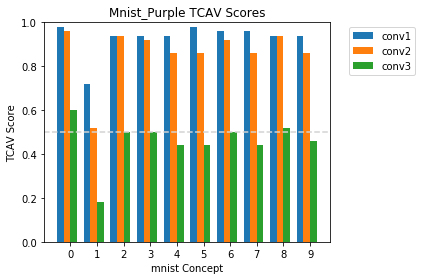

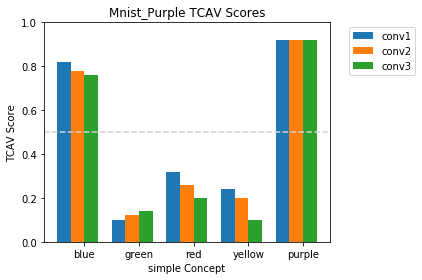

In [5]:
is_bonferroni = False
for results in results_lst:
    #utils_plot.plot_concept_results(results, root_dir + 'log/' + project_names + '/plot')
    utils_plot.plot_concept_results(results)

In [26]:
grad = np.mean(np.array(pickle_load('/home/tomohiro/code/tcav/log/3layer-mnist/cavs/grad:conv1:mnist_purple')),0)
cav = get_true_cav_mean(root_dir + 'log/' + project_names + '/cavs', 'conv1', 'mnist_0')

print(-np.dot(grad,cav))
print(cos_sim(grad,cav))


-0.004665764
0.033871077


In [32]:
grad = np.array(pickle_load('/home/tomohiro/code/tcav/log/3layer-mnist/cavs/grad:conv1:mnist_purple'))
cav = get_true_cav_mean(root_dir + 'log/' + project_names + '/cavs', 'conv1', 'mnist_0')
lst = [np.dot(-grad[i],cav) < 0 for i in range(len(grad))]
print(lst)


[True, True, True, False, True, False, False, False, True, False, True, False, False, True, False, True, True, True, True, True, True, True, False, True, True, False, True, True, False, True, True, False, True, False, True, False, True, False, True, True, False, False, True, True, False, True, True, True, False, True]


In [34]:
np.sum(lst)

31

In [28]:
grad.shape

(627264,)

In [13]:
cav.shape

(627264,)

## CAVベクトルの類似度を算出

In [40]:
project_names = '3layer-mnist'
bottlenecks = ['conv1', 'conv2', 'conv3']
concepts = ['mnist_0','mnist_1','mnist_2','mnist_3','mnist_4','mnist_5','mnist_6','mnist_7','mnist_8','mnist_9']
cavs_path = root_dir + 'log/' + project_names + '/cavs'
# cavs_path.sort()
# for path in cavs_path:
#     if keyword == path.split(':')[0]:
#         print(path)
#         cav_path[path.split(':')[0]] = path

In [10]:
# def get_cav_mean(path, bottleneck, concept):
#     cnt = 0
#     for cav_dir in os.listdir(path):
#         if 'cav' in cav_dir:
#             b, _, c = cav_dir.split(':')
#             b = b.split('-')[1]
#             if b == bottleneck and concept in c:
#                 if cnt == 0:
#                     cav_values = np.array(pickle_load(path + '/' + cav_dir))
#                     cav_mean = np.mean(cav_values,0)
#                 else:
#                     cav_values = np.array(pickle_load(path + '/' + cav_dir))
#                     cav_mean += np.mean(cav_values,0)
#                 cnt += 1
#     cav_mean /= cnt
#     return cav_mean

def get_cav_mean(path, bottleneck, concept):
    cnt = 0
    for cav_dir in os.listdir(path):
        if cav_dir.split(':')[0] != 'cav':
            continue
        t, c, nc, b = cav_dir.split(':')
        b = b.split('.')[0]
        if b == bottleneck and c == concept:
            if cnt == 0:    
                cav_values = np.array(pickle_load(path + '/' + cav_dir)['cavs'][0])
            else:
                cav_values += np.array(pickle_load(path + '/' + cav_dir)['cavs'][0])
            cnt += 1
    cav_values /= cnt
    return cav_values

def get_true_cav_mean(path, bottleneck, concept):
    cnt = 0
    for cav_dir in os.listdir(path):
        if cav_dir.split(':')[0] != 'cav-true':
            continue
        t, en, c, b = cav_dir.split(':')
        if b == bottleneck and c == concept:
            if cnt == 0:    
                cav_values = np.array(pickle_load(path + '/' + cav_dir))
            else:
                cav_values += np.array(pickle_load(path + '/' + cav_dir))
            cnt += 1
    cav_values /= cnt
    return cav_values

def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [290]:
#lst = []
#concepts = ['mnist_0','mnist_1','mnist_2','mnist_3','mnist_4','mnist_5','mnist_6','mnist_7','mnist_8','mnist_9']
concepts = ['simple-blue','simple-green','simple-red','simple-yellow','simple-purple']
bottleneck = 'conv1'
for v in itertools.combinations(concepts, 2):
    print('---------------------')
    print(f'{v[0]} vs {v[1]}')
    print(np.round(cos_sim(get_cav_mean(cavs_path, bottleneck, v[0]),get_cav_mean(cavs_path, bottleneck, v[1])),2))
    # tmp = np.round(cos_sim(get_cav_mean('cav',cavs_path, bottleneck, v[0]),get_cav_mean('cav',cavs_path, bottleneck, v[1])),2)
    # print(tmp)
    # lst.append(tmp)
# print(np.round(np.mean(lst),2))
# print(np.round(np.std(lst),2))
# print(np.round(np.min(lst),2))
# print(np.round(np.max(lst),2))

---------------------
simple-blue vs simple-green
-0.07
---------------------
simple-blue vs simple-red
-0.0
---------------------
simple-blue vs simple-yellow
-0.41
---------------------
simple-blue vs simple-purple
0.65
---------------------
simple-green vs simple-red
-0.28
---------------------
simple-green vs simple-yellow
0.53
---------------------
simple-green vs simple-purple
-0.63
---------------------
simple-red vs simple-yellow
0.41
---------------------
simple-red vs simple-purple
0.51
---------------------
simple-yellow vs simple-purple
-0.48


In [289]:
#lst = []
#concepts = ['mnist_0','mnist_1','mnist_2','mnist_3','mnist_4','mnist_5','mnist_6','mnist_7','mnist_8','mnist_9']
concepts = ['simple-blue','simple-green','simple-red','simple-yellow','simple-purple']
bottleneck = 'conv1'
for v in itertools.combinations(concepts, 2):
    print('---------------------')
    print(f'{v[0]} vs {v[1]}')
    print(np.round(cos_sim(get_true_cav_mean(cavs_path, bottleneck, v[0]),get_true_cav_mean(cavs_path, bottleneck, v[1])),2))
#     tmp = np.round(cos_sim(get_true_cav_mean(cavs_path, bottleneck, v[0]),get_true_cav_mean(cavs_path, bottleneck, v[1])),2)
#     lst.append(tmp)
# print(np.round(np.mean(lst),2))
# print(np.round(np.std(lst),2))
# print(np.round(np.min(lst),2))
# print(np.round(np.max(lst),2))

---------------------
simple-blue vs simple-green
0.05
---------------------
simple-blue vs simple-red
0.2
---------------------
simple-blue vs simple-yellow
0.19
---------------------
simple-blue vs simple-purple
0.71
---------------------
simple-green vs simple-red
0.23
---------------------
simple-green vs simple-yellow
0.71
---------------------
simple-green vs simple-purple
0.15
---------------------
simple-red vs simple-yellow
0.81
---------------------
simple-red vs simple-purple
0.78
---------------------
simple-yellow vs simple-purple
0.61


## Sensitivityの計算

In [205]:
#Sの値
def get_predict(path, target):
    for dir in os.listdir(path):
        if dir.split(':')[0] != 'predict':
            continue
        _, t = dir.split(':')
        if t == target:
            values = np.array(pickle_load(path + '/' + dir))
    return values

def get_grad(path, bottleneck, target):
    for dir in os.listdir(path):
        if dir.split(':')[0] != 'grad':
            continue
        _, b,t = dir.split(':')
        if b == bottleneck and t == target:
            values = np.array(pickle_load(path + '/' + dir))
    return values


def get_sensitivity(type,path, bottleneck, concept,target):
    pred = get_predict(cavs_path, target)
    grad = get_grad(cavs_path, 'conv1',target)
    cnt = 0
    for cav_dir in os.listdir(path):
        if cav_dir.split(':')[0] != type:
            continue
        t, c, nc, b = cav_dir.split(':')
        b = b.split('.')[0]
        if b == bottleneck and c == concept:
            if cnt == 0:    
                cav_values = np.array(pickle_load(path + '/' + cav_dir)['cavs'][0])
                s = np.array([np.dot(-(1-pred[i])*grad[i],cav_values) for i in range(len(pred))])
            else:
                cav_values = np.array(pickle_load(path + '/' + cav_dir)['cavs'][0])
                s = np.append(s,np.array([np.dot(-(1-pred[i])*grad[i],cav_values) for i in range(len(pred))]))
            cnt += 1
    return s

In [218]:
target = 'mnist_purple'
concept = 'mnist_0'
bottleneck = 'conv1'
s = get_sensitivity('cav',cavs_path, bottleneck, concept,target)

target = 'mnist_yellow'
concept = 'mnist_0'
bottleneck = 'conv1'
s2 = get_sensitivity('cav',cavs_path, bottleneck, concept,target)

target = 'mnist_blue'
concept = 'simple-blue'
bottleneck = 'conv1'
s3 = get_sensitivity('cav',cavs_path, bottleneck, concept,target)

In [219]:
print(s.mean())
print(s.std())
print(s.min())
print(s.max())

1.604840401500444e-05
0.00013263508895375672
-6.604803839506813e-07
0.002381931634274029


In [220]:
print(s2.mean())
print(s2.std())
print(s2.min())
print(s2.max())

3.1255865956517436e-07
2.5216080659228683e-06
-1.3328443931010254e-05
3.577497269152954e-05


In [221]:
print(s3.mean())
print(s3.std())
print(s3.min())
print(s3.max())

1.6703473690800593e-07
8.416456602590745e-07
0.0
1.1530566772206697e-05


## Activationについて

In [310]:
acts_path = root_dir + 'log/' + project_names + '/activations'
bottleneck = 'conv1'
concepts = ['mnist_purple','mnist_0']
acts_lst = []
for concept in concepts:
    for dir in os.listdir(acts_path):
        c = dir[5:-6]
        b = dir[-5:]
        if concept == c and bottleneck == b:
            with tf.io.gfile.GFile(acts_path + '/' + dir, 'rb') as f:
                act = np.load(f, allow_pickle=True)
            acts_lst.append(act)

In [ ]:
acts_lst

In [308]:
act.shape

(50, 198, 198, 16)

In [ ]:
act - 

In [254]:
act_path = ['/home/tomohiro/code/tcav/log/3layer-mnist/activations/acts_mnist_0_conv1','/home/tomohiro/code/tcav/log/3layer-mnist/activations/acts_random500_0_conv1']
for i, path in enumerate(act_path):
    if i == 0:
        with tf.io.gfile.GFile(path, 'rb') as f:
            act = np.load(f, allow_pickle=True)
    else:
        with tf.io.gfile.GFile(path, 'rb') as f:
            np.append(act, np.load(f, allow_pickle=True))
act = act.reshape(50*i,-1)
pca = PCA(n_components=2)
pca_values = pca.fit_transform(act)

In [256]:
pca_values

array([[ 77.648865 ,  49.731567 ],
       [-53.210964 , -79.30876  ],
       [ 94.251976 , -13.9039955],
       [-20.00605  ,  42.630833 ],
       [-41.32144  ,  41.613865 ],
       [ 86.96004  ,   2.9563465],
       [-79.02567  ,   4.3160954],
       [-72.08152  , -17.17565  ],
       [ -8.703195 ,  77.626686 ],
       [-52.10469  , -69.73956  ],
       [ 54.80048  ,  50.378212 ],
       [-77.01597  ,  -0.5793052],
       [-86.48369  ,  29.408993 ],
       [-21.94041  , -86.7147   ],
       [-20.413671 , -34.07604  ],
       [-68.98827  , -49.980427 ],
       [-58.204075 ,  50.66273  ],
       [ 27.98165  ,  80.99525  ],
       [-19.441631 ,  89.756256 ],
       [ 80.3784   ,  26.558552 ],
       [ 12.581553 ,  54.712418 ],
       [-33.46917  , -37.375484 ],
       [ 52.458523 , -78.76841  ],
       [ 33.496937 , -53.743977 ],
       [-81.465965 , -47.17656  ],
       [-52.31717  , -12.017218 ],
       [ 51.60101  , -25.57111  ],
       [ 50.267693 ,  18.286726 ],
       [-65.90214  ,